In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
data = pd.read_csv('test_bitmex_1h.csv')

# 데이터 기본 정보 보기

In [3]:
data.columns

Index(['coin', 'symbol', 'time', 'vwap', 'volume'], dtype='object')

In [4]:
data.shape

(50284, 5)

In [5]:
data.info() ## 가격데이터 nan 값이 존재

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50284 entries, 0 to 50283
Data columns (total 5 columns):
coin      50284 non-null object
symbol    50284 non-null object
time      50284 non-null object
vwap      49967 non-null float64
volume    50284 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.9+ MB


In [6]:
data.describe(include= 'all')

,coin,symbol,time,vwap,volume
count,50284,50284,50284,49967.000000,5.028400e+04
unique,1,12,23897,NaN,NaN
top,XBT,XBTU19,2018-09-19 23:00:00,NaN,NaN
freq,50284,4709,3,NaN,NaN
mean,NaN,NaN,NaN,7938.416557,1.885971e+06
std,NaN,NaN,NaN,2580.735719,3.224210e+06
min,NaN,NaN,NaN,3055.766457,0.000000e+00
25%,NaN,NaN,NaN,6380.342326,3.969668e+05
50%,NaN,NaN,NaN,8035.989749,9.648405e+05
75%,NaN,NaN,NaN,9634.611483,2.192922e+06


# 형변환

In [7]:
data['time'] = pd.to_datetime(data['time']) ## 시간 변수를 다루기 좋게 변환. 

# 결측치 분석

### 요약:
### 근월물 만기일에 원월물 데이터가 없는 경우가 존재 -> 이 경우는 거래가 불가능한 것으로 가정. 일정기간 동안 완전히 거래가 불가능하므로 아예 데이터에서 제거
### 분기말의 일정 기간 동안 3개의 선물이 거래되는 경우가 있다. -> 겹치는 기간에는 하나만 거래할 수 있는 것으로 가정(백테스트의 단순성을 위한 가정)
### 2시간, 3시간의 결측치는 기술적인 문제, 시장 교란, 과열 등의 문제로 거래가 멈춘 경우로 볼 수 있다. -> 이 경우도 거래가 불가능한 경우로 가정. 데이터는 결측치로 일단 두고, 전략, 백테스트에서 수정

In [8]:
data[data['volume']==0]

,coin,symbol,time,vwap,volume
4156,XBT,XBTM18,2018-03-30 13:00:00,NaN,0
4157,XBT,XBTM18,2018-03-30 14:00:00,NaN,0
4158,XBT,XBTM18,2018-03-30 15:00:00,NaN,0
4159,XBT,XBTM18,2018-03-30 16:00:00,NaN,0
4160,XBT,XBTM18,2018-03-30 17:00:00,NaN,0
...,...,...,...,...,...
45357,XBT,XBTZ20,2020-06-18 04:00:00,NaN,0
45681,XBT,XBTZ20,2020-06-22 16:00:00,NaN,0
45726,XBT,XBTZ20,2020-06-23 07:00:00,NaN,0
45810,XBT,XBTZ20,2020-06-24 11:00:00,NaN,0


In [9]:
data[data['vwap'].isnull()]

,coin,symbol,time,vwap,volume
4156,XBT,XBTM18,2018-03-30 13:00:00,NaN,0
4157,XBT,XBTM18,2018-03-30 14:00:00,NaN,0
4158,XBT,XBTM18,2018-03-30 15:00:00,NaN,0
4159,XBT,XBTM18,2018-03-30 16:00:00,NaN,0
4160,XBT,XBTM18,2018-03-30 17:00:00,NaN,0
...,...,...,...,...,...
45357,XBT,XBTZ20,2020-06-18 04:00:00,NaN,0
45681,XBT,XBTZ20,2020-06-22 16:00:00,NaN,0
45726,XBT,XBTZ20,2020-06-23 07:00:00,NaN,0
45810,XBT,XBTZ20,2020-06-24 11:00:00,NaN,0


In [10]:
(data[data['vwap'].isnull()].index != data[data['volume']==0].index).sum()
## volume이 0인 경우는 전부 vwap이 결측치인 경우이다.

0

C:\Users\dlcks\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


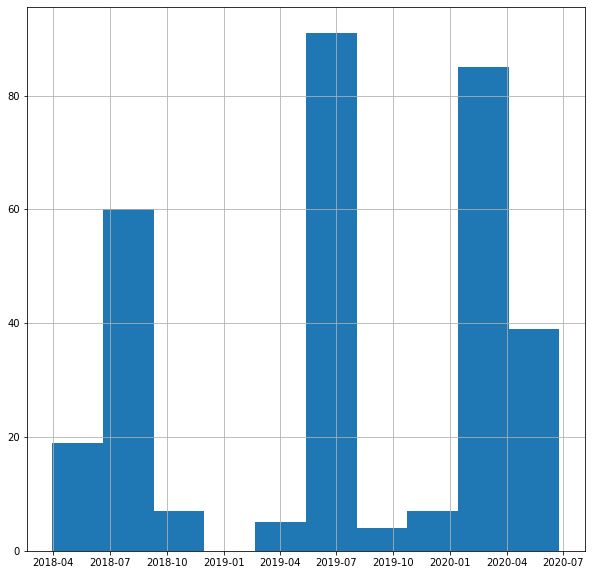

In [11]:
data[data['vwap'].isnull()]['time'].hist(figsize=(10,10))
## 만기일 근처 외에도 결측치가 간간이 있다.

# 데이터 정리 
## (근월물, 원월물) 형태로 데이터를 정리 후 결측치 처리

In [12]:
symbol_part1 = ['XBT']
symbol_part2 = ['18', '19','20']
symbol_part3 = ['H', 'M', 'U', 'Z']
symbols = []
for _1 in symbol_part1:
    for _2 in symbol_part2:
        for _3 in symbol_part3:
            symbols.append(_1+_3+_2)
symbols

['XBTH18',
 'XBTM18',
 'XBTU18',
 'XBTZ18',
 'XBTH19',
 'XBTM19',
 'XBTU19',
 'XBTZ19',
 'XBTH20',
 'XBTM20',
 'XBTU20',
 'XBTZ20']

In [13]:
## 원월물과 근월물 리스트로 정리
near_far_list = []
for i in range(len(symbols)):
    near_symbol = symbols[i]
    if i+1==len(symbols): break
    far_symbol = symbols[i+1]
    near_far = pd.merge(left=data[data['symbol']==near_symbol], right=data[data['symbol']==far_symbol], on='time')
    near_far_list.append(near_far)
near_far_df = pd.concat(near_far_list)
near_far_df.reset_index(inplace=True, drop=True)
near_far_df = near_far_df.drop('coin_y',axis=1)
near_far_df['spread'] = near_far_df['vwap_y'] - near_far_df['vwap_x']
near_far_df = near_far_df[['coin_x', 'time', 'symbol_x', 'symbol_y', 'vwap_x', 'vwap_y', 'spread', 'volume_x', 'volume_y']]
near_far_df.columns = ['coin', 'time','near_symbol', 'far_symbol', 'vwap_near', 'vwap_far', 'spread', 'volume_near', 'volume_far']

In [114]:
near_far_df.to_csv('near_far_df.csv')
near_far_df.to_pickle('near_far_df.pkl')

In [15]:
near_far_df

,coin,time,near_symbol,far_symbol,vwap_near,vwap_far,spread,volume_near,volume_far
0,XBT,2018-01-02 23:00:00,XBTH18,XBTM18,15857.539468,17955.225722,2097.686253,3395065,151361
1,XBT,2018-01-03 00:00:00,XBTH18,XBTM18,16095.653652,17512.403599,1416.749946,3880638,3991030
2,XBT,2018-01-03 01:00:00,XBTH18,XBTM18,16015.590702,18183.519680,2167.928978,1017262,3639333
3,XBT,2018-01-03 02:00:00,XBTH18,XBTM18,16170.207639,17404.895810,1234.688170,2479906,322148
4,XBT,2018-01-03 03:00:00,XBTH18,XBTM18,16240.848903,17806.199313,1565.350410,4587485,4973513
...,...,...,...,...,...,...,...,...,...
26382,XBT,2020-09-24 11:00:00,XBTU20,XBTZ20,10398.394456,10506.157375,107.762919,1089983,2222261
26383,XBT,2020-09-24 12:00:00,XBTU20,XBTZ20,10385.575787,10506.570149,120.994362,509872,785774
26384,XBT,2020-09-24 13:00:00,XBTU20,XBTZ20,10363.081012,10460.789864,97.708853,490564,722780
26385,XBT,2020-09-24 14:00:00,XBTU20,XBTZ20,10388.216869,10500.852793,112.635924,468308,873974


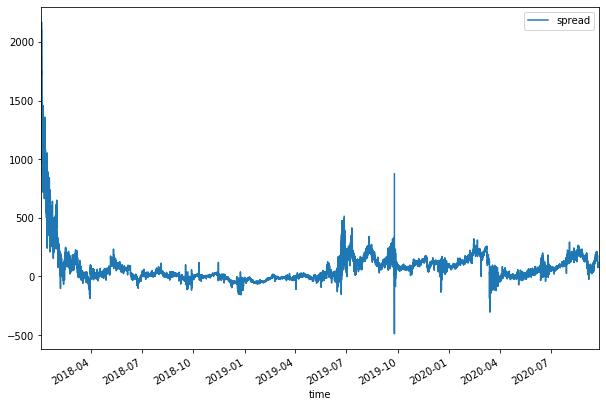

In [16]:
near_far_df.plot(x='time', y=['spread'], figsize=(10,7) )

### 근월물 만기일에 원월물 데이터가 없는 경우가 존재
### 분기말의 일정 기간 동안 3개의 선물이 거래되는 경우가 있다.

In [17]:
for symbol in symbols:
    print('{0}의 시작점: {1}'.format(symbol,data[data['symbol']==symbol].iloc[0]['time']))
    print('{0}의 만기 : {1}'.format(symbol,data[data['symbol']==symbol].iloc[-1]['time']))
    print('\n')
    ## XBTU18, XBTZ18의 시작점은 그 이전 선물의 만기 이후에 있지만, 
    ## 나머지는 전부 2개 분기 이전 선물의 만기가 끝나기 전에 거래가 시작된다.
    ## 18년 3분기물의 만기가 오기 전에 19년 1분기물의 거래가 시작된다. 
    ## 따라서 이 기간(20180917 03:00:00 - 20180928 12:00:00)에는 XBTU18, XBTM18, XBTH19의 3개 선물이 거래된다.

XBTH18의 시작점: 2018-01-02 23:00:00
XBTH18의 만기 : 2018-03-30 12:00:00


XBTM18의 시작점: 2018-01-02 23:00:00
XBTM18의 만기 : 2018-06-29 12:00:00


XBTU18의 시작점: 2018-03-31 06:00:00
XBTU18의 만기 : 2018-09-28 12:00:00


XBTZ18의 시작점: 2018-07-02 01:00:00
XBTZ18의 만기 : 2018-12-28 11:00:00


XBTH19의 시작점: 2018-09-17 03:00:00
XBTH19의 만기 : 2019-03-29 12:00:00


XBTM19의 시작점: 2018-12-17 04:00:00
XBTM19의 만기 : 2019-06-28 12:00:00


XBTU19의 시작점: 2019-03-15 08:00:00
XBTU19의 만기 : 2019-09-27 12:00:00


XBTZ19의 시작점: 2019-06-14 09:00:00
XBTZ19의 만기 : 2019-12-27 11:00:00


XBTH20의 시작점: 2019-09-13 08:00:00
XBTH20의 만기 : 2020-03-27 12:00:00


XBTM20의 시작점: 2019-12-13 08:00:00
XBTM20의 만기 : 2020-06-26 12:00:00


XBTU20의 시작점: 2020-03-14 07:00:00
XBTU20의 만기 : 2020-09-24 15:00:00


XBTZ20의 시작점: 2020-06-12 08:00:00
XBTZ20의 만기 : 2020-09-24 15:00:00




In [18]:
near_far_df[near_far_df['spread'].isnull()] 
## 만기 결제일을 제외하고 거래량이 없는 경우는 시장교란으로 인해 일시중단된 경우일 수 있다.
## 홈페이지에 나와있는 내용 :
## ""비트멕스가 일시적으로 거래를 중단하는 경우, 시장교란 (MDE)이 공식적으로 발생 할 경우 발표됩니다. 이러한 시장교란 발생으로 인해 거래자들의 계약에 대한 결산 또는 만기일의 변경은 이메일을 통해 공지되며, 해당 내용이 거래 대시보드에 게시됩니다.""
## 이 부분은 어떻게 시장전략을 짤 것인지에 따라 바뀔 것이다.


,coin,time,near_symbol,far_symbol,vwap_near,vwap_far,spread,volume_near,volume_far
3221,XBT,2018-05-17 21:00:00,XBTM18,XBTU18,NaN,NaN,NaN,0,0
6196,XBT,2018-09-21 08:00:00,XBTU18,XBTZ18,6666.835418,NaN,NaN,6974787,0
6470,XBT,2018-09-21 08:00:00,XBTZ18,XBTH19,NaN,6582.02629,NaN,0,1467184
7163,XBT,2018-10-20 05:00:00,XBTZ18,XBTH19,NaN,NaN,NaN,0,0
7333,XBT,2018-10-27 07:00:00,XBTZ18,XBTH19,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...
24023,XBT,2020-06-18 04:00:00,XBTU20,XBTZ20,9479.969073,NaN,NaN,595214,0
24131,XBT,2020-06-22 16:00:00,XBTU20,XBTZ20,9638.884063,NaN,NaN,2934250,0
24146,XBT,2020-06-23 07:00:00,XBTU20,XBTZ20,9717.669847,NaN,NaN,223418,0
24174,XBT,2020-06-24 11:00:00,XBTU20,XBTZ20,9396.200906,NaN,NaN,2879561,0


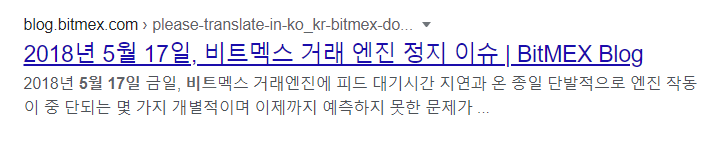

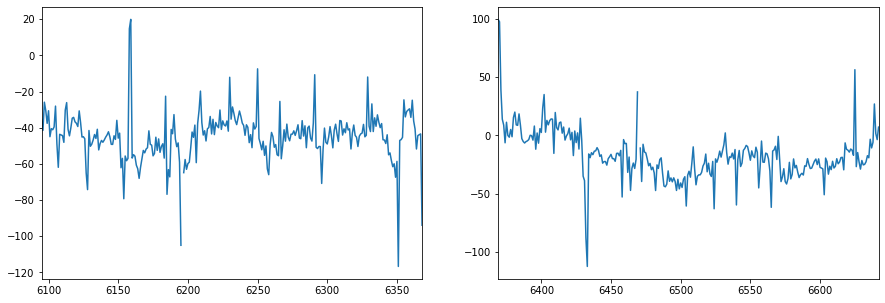

In [19]:
plt.subplot(121)
near_far_df[near_far_df['far_symbol']=='XBTZ18'].iloc[-274:]['spread'].plot(figsize=(15,5))
plt.subplot(122)
near_far_df[near_far_df['far_symbol']=='XBTH19'].iloc[:274]['spread'].plot(figsize=(15,5))

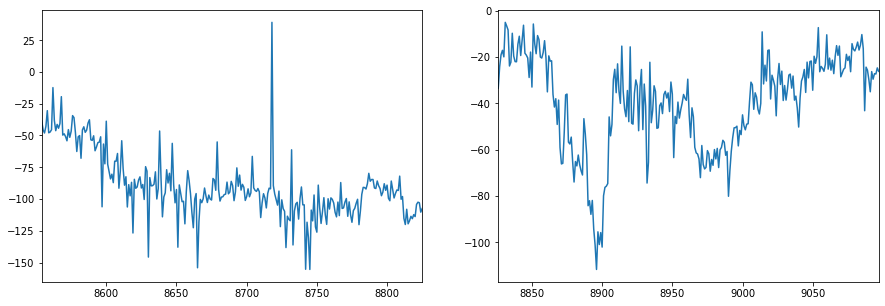

In [20]:
plt.subplot(121)
near_far_df[near_far_df['far_symbol']=='XBTH19'].iloc[-272:]['spread'].plot(figsize=(15,5))
plt.subplot(122)
near_far_df[near_far_df['far_symbol']=='XBTM19'].iloc[:272]['spread'].plot(figsize=(15,5))

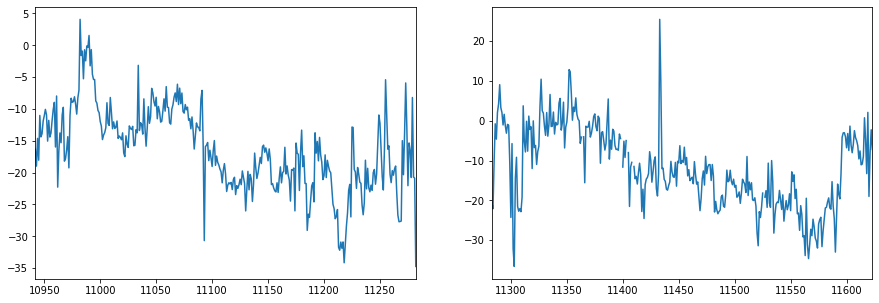

In [21]:
plt.subplot(121)
near_far_df[near_far_df['far_symbol']=='XBTM19'].iloc[-341:]['spread'].plot(figsize=(15,5))
plt.subplot(122)
near_far_df[near_far_df['far_symbol']=='XBTU19'].iloc[:341]['spread'].plot(figsize=(15,5))

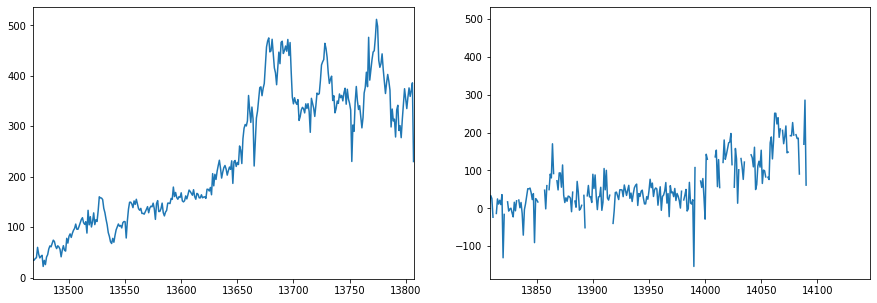

In [22]:
plt.subplot(121)
near_far_df[near_far_df['far_symbol']=='XBTU19'].iloc[-340:]['spread'].plot(figsize=(15,5))
plt.subplot(122)
near_far_df[near_far_df['far_symbol']=='XBTZ19'].iloc[:340]['spread'].plot(figsize=(15,5))

## 가정 : (차월물,차차월물) 거래가 가능한 시점을 (근월물, 차월물) 만기 시점이라고 가정. 차차월물 거래 시작 시점부터 근월물 실제 만기 시점까지 (근월물, 차월물) 거래데이터를 삭제

In [23]:
near_far_df_fined = near_far_df.copy().reset_index(drop=True)

In [24]:
for i in range(1,len(near_far_df_fined)):
    is_reversed = near_far_df_fined['time'][i] < near_far_df_fined['time'][i-1]
    if is_reversed:
        near_mature_index = i
        farfar_start_time = near_far_df_fined['time'][i]
        farfar_start_index = near_far_df_fined[near_far_df_fined['time']==farfar_start_time].iloc[0].name
        if farfar_start_index < near_mature_index:
            drop_target = range(farfar_start_index, near_mature_index)
            near_far_df_fined.drop(drop_target, inplace=True)   
    
near_far_df_fined.reset_index(inplace=True, drop=True)
near_far_df_fined

,coin,time,near_symbol,far_symbol,vwap_near,vwap_far,spread,volume_near,volume_far
0,XBT,2018-01-02 23:00:00,XBTH18,XBTM18,15857.539468,17955.225722,2097.686253,3395065,151361
1,XBT,2018-01-03 00:00:00,XBTH18,XBTM18,16095.653652,17512.403599,1416.749946,3880638,3991030
2,XBT,2018-01-03 01:00:00,XBTH18,XBTM18,16015.590702,18183.519680,2167.928978,1017262,3639333
3,XBT,2018-01-03 02:00:00,XBTH18,XBTM18,16170.207639,17404.895810,1234.688170,2479906,322148
4,XBT,2018-01-03 03:00:00,XBTH18,XBTM18,16240.848903,17806.199313,1565.350410,4587485,4973513
...,...,...,...,...,...,...,...,...,...
23815,XBT,2020-09-24 11:00:00,XBTU20,XBTZ20,10398.394456,10506.157375,107.762919,1089983,2222261
23816,XBT,2020-09-24 12:00:00,XBTU20,XBTZ20,10385.575787,10506.570149,120.994362,509872,785774
23817,XBT,2020-09-24 13:00:00,XBTU20,XBTZ20,10363.081012,10460.789864,97.708853,490564,722780
23818,XBT,2020-09-24 14:00:00,XBTU20,XBTZ20,10388.216869,10500.852793,112.635924,468308,873974


In [113]:
near_far_df_fined.to_pickle('near_far_df_fined.pkl')
near_far_df_fined.to_csv('near_far_df_fined.csv')

In [26]:
near_far_df_fined = pd.read_pickle('near_far_df_fined.pkl')

# 선물가격의 기본적 흐름 보기

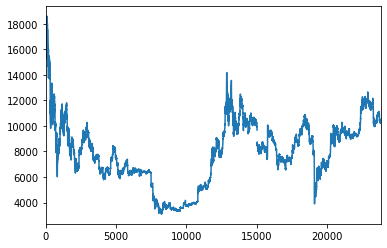

In [27]:
near_far_df_fined['vwap_near'].plot()

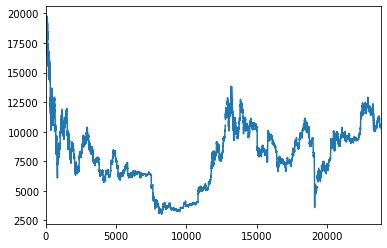

In [28]:
near_far_df_fined['vwap_far'].plot()

In [29]:
spread_ratio = near_far_df_fined['spread'] / near_far_df_fined['vwap_near']

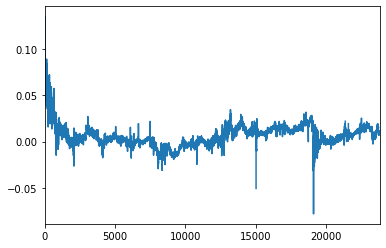

In [30]:
spread_ratio.plot()

## 근월물, 원월물 가격 자체는 중장기적 흐름을 타고 변동하지만, 선물 스프레드는 평균을 중심으로 단기적으로 UP, DOWN을 반복하는 형태이다. 

# Utility Funtion

In [31]:
def get_changing_times(data): ## 월물이 교체되는 시기를 찾아내는 함수
    change_times =[]
    for i in range(1,len(data)):
        if data['near_symbol'].iloc[i]!=data['near_symbol'].iloc[i-1]:
            ch_time = data['time'].iloc[i]
            change_times.append(ch_time)
    return change_times
def get_changing_index(data,change_times): ## 월물이 교체되는 시기를 찾아내는 함수
    change_times_index =[0] ## 시작시점
    for ch_time in change_times:        
        index = data[data['time']==ch_time].index.values[0]
        change_times_index.append(index)
    change_times_index.append(len(data))
    return change_times_index

# Backtest 함수 만들기

전략 가정 1 : 1 XBT의 자금만으로 운용. (납입과 인출 없음. 백테스팅의 단순성을 위한 가정. 실제로는 사업 모델상, 투자상황상 납입과 인출이 필요할 수 있다.  사업 모델을 생각해보면, 예금이나 투자금을 운용하는 경우 시간이 지나면서 추가 납입을 하거나 이자 지급을 위해 인출이 필요할 수 있다.  투자 상황을 생각해보면, 포지션이 강제 청산될 위험에 처했을 때 추가 납입이 필요할 수 있다. 하지만 투자상황상 청산을 피하기 위한 추가납입은 크게 고려하지 않아도 될 것으로 판단한다. 왜냐하면 저위험 중수익이라는 목표를 달성하기 위해서 청산당할 정도의 leverage를 이용하는 것이 부적절하므로, 투자를 할 때는 일반적으로 낮은 수준의 레버리지를 이용할 것이다. 이에 따라 청산을 피하기 위한 추가납입은 거의 없을 것으로 예상함. 강력한 모멘텀 시기에 레버리지를 늘려서 투자할 때는 Isolated margin으로 주문을 넣어서 상황이 뒤집히면 해당 주문만 청산함으로써 손실폭을 제한하는 것이 더 낫다고 생각한다.)  
 
-> 시간이 있다면 수정할 사안 : 한번의 포지션이 청산이 끝나면 1 XBT의 원금으로 되돌린다. 연속으로 손실이 날 때 청산될 수 있다. 이 때는 금액 가중 평균 수익률을 통해 전체 수익을 평가할 수 있다.
 
전략 가정 2 : 근월물의 레버리지와 원월물의 레버리지는 계속 일정하게 유지한다고 가정. 근월물과 원월물의 투자비중도 계속 유지한다고 가정. (근월물에 0.4 XBT, 원월물에 0.6 XBT를 투자하고 각각 레버리지를 5배 이용하면, 포지션 진입 시 근월물의 포지션 크기는 2 XBT, 원월물의 포지션 크기는 0.6*5=3 XBT가 된다. 이러한 포지션을 매 기간 이용한다. 백테스팅의 단순성을 위한 가정. 실제로 전략을 짤 때는 중요한 변수가 된다.)

전략 가정 3 : 근월물 매수, 원월물 매도를 전략만 사용한다. 스프레드가 확대되었을 때 진입하여, 스프레드가 축소되면 포지션 청산. 포지션에 진입할지, 청산할지만 결정
즉, 포지션은 한번에 진입하고, 한번에 청산함. 단순성을 위해서 포지션을 일부만 청산하는 경우는 제외. 실제로 투자할 때는 스프레드 축소 모멘텀이 강할 때 포지션 크기를 늘리고, 모멘텀이 약해질 때 점진적으로 포지션 크기를 줄임으로써 수익 변동성을 줄일 수 있다.

전략 가정 4 : 포지션에 진입하지 않으면 수익이 없는 것으로 가정
무기한 선물을 매수하여 funding rate를 얻을 수도 있지만, 무기한 선물의 가격 변동에 노출되므로 이를 고려한 전략을 짜려면 무기한 선물 가격 변동 데이터도 필요하다. 

전략 가정 3 : Cross Margin으로만 주문을 넣음. 
단순성을 위한 가정이다. Isolated Margin은 고배율로 확실한 추세가 있을 때 청산 위험을 감수하면서도 청산이 제한적인 범위에서 진행되도록 주문이므로, 저위험 중수익을 위해서는 포트폴리오에 있어야 한다고 생각하지만 이를 고려하려면 백테스팅이 복잡해질 것 같아서 제외

전략 가정 5 : 수수료를 고려한 margin이 0보다 작아지면 청산 가정(단순성을 위한 가정, 실제로는 그 전에 Maintenance Margin에 도달하면 청산된다.)

전략 가정 6 : 청산가격의 기준이 되는 가격은 vwap.
주어진 데이터가 제한적이기에 필요한 가정. 실제로는 다른 거래소의 데이터들과 합쳐서 만든 Mark price를 기준으로 청산

주문에 대한 가정
1. Taking만 한다. 
단순성을 위한 가정. 비트맥스는 메이커에 대한 리베이트를 제공하므로, 실제 투자에는 이를 이용할 수 있다.
2. Bid와 Ask의 대용치로 vwap을 쓴다.
주어진 데이터에 가격 데이터는 vwap 하나뿐이므로 필요한 가정. 실제로는 order book의 물량을 보고 결정해야 하며, 기본적으로 매수호가와 매도호가의 차이가 존재한다.
3. 주문과 청산은 정시에만 시간대별로 발생한다고 가정. Mark Price가 아닌 거래소 가격대로 청산
단순성과 데이터의 제한. 시간대별 가격 밖에 주어지지 않았기 때문이다. 실제로는 매순간 해당 시점의 order_book에 따라 거래가 이루어진다.

In [32]:
def backtest(data, n_mar, f_mar, n_lev, f_lev, in_standard, out_standard, commission=0.00075):
    data.reset_index(drop=True, inplace=True)
    realized_bal = []
    realized_bal_com = []
    realized_bal.append(n_mar+f_mar) ## 수수료 없는 경우
    realized_bal_com.append(n_mar+f_mar) ## 수수료 있는 경우
    near_price = data['vwap_near']
    far_price = data['vwap_far']
    inout_timing = data['inout_timing']
    inout_state = data['inout_state']
    trade_commission = commission*(n_mar*n_lev + f_mar*f_lev)
    var = ['vwap_near', 'vwap_far','volume_near','volume_far']
    
   
    
    
    for i in range(1, len(data)):
        is_null_data = data[var].iloc[i].isnull().sum() > 0
        isin = inout_state[i]       
        
        if ~is_null_data:
            if isin & (inout_timing[i]=='start'): ## 포지션 진입 시점. 가격을 결정
                entry_near = near_price.iloc[i]
                entry_far = far_price.iloc[i]
                start_bal = realized_bal[i-1]
                start_bal_com = realized_bal_com[i-1]
                realized_bal.append(realized_bal[i-1])
                realized_bal_com.append(realized_bal_com[i-1]-trade_commission)
                
            elif inout_timing[i]=='in': ## 포지션에 있는 동안 available balance 조정                
                profit = (1-entry_near/near_price[i])*n_mar*n_lev -(1-entry_far/far_price[i])*f_mar*f_lev
                realized_bal_with_profit = start_bal + profit
                realized_bal_com_with_profit = start_bal_com + profit
                ## backtest에서 profit 값이 nan이 되지 않게
                ## entry_near, entry_far, near_price[i], far_price[i] 중 하나라도 결측치가 있으면 
                ## 이후의 profit 모두 nan이 된다.

                isliqu = realized_bal_with_profit<=0
                isliqu_com = realized_bal_com_with_profit<=0
                ## 수수료가 있는 경우의 수익이 당연히 더 작을 수 밖에 없으므로
                ## 수수료가 있는 경우만 기준으로 할 수도 있지만
                ## 나중에 maker fee로 변경하는 경우에는 꼭 그렇지
                if ~isliqu & ~isliqu_com :
                    realized_bal.append(realized_bal_with_profit)
                    if isin: ## In 상태 유지                  
                        realized_bal_com.append(realized_bal_com_with_profit)
                    else: ## OUT하는 시점
                        realized_bal_com.append(realized_bal_com_with_profit-trade_commission)
                        
                else: 
                    print('Your Position Is Liquidated on {0} '.format(data['time'][i]))
                    realized_bal.append(None)
                    realized_bal_com.append(0)
                    for j in range(i, len(data)):                       
                        inout_timing.iloc[j]='liq'
                    ## 어려움 : 둘 중에 하나만 청산되는 경우, 나머지의 흐름은 따로 진행시키고 싶은데 지금은 그렇게
                    ## 시그널을 줄 수 없다. 만약 두 흐름이 거래되는 시그널을 바꾼다면 위의 if 구문을 다 수정해야 한다.
                    ## 따로 함수를 만들어야한다.
                    ## 그렇게 수정하려면 시간이 걸릴 것 같아 일단 둘 중 하나라도 청산되면 같이 청산한다고 가정.
                    ## 실제로는 청산당하지 않게 자본금을 더 납입했을 때 어느 정도 돈을 더 버는지 볼 수 있다.
            
                
            else: ## OUT인 상태 유지 
                ## liqu되면 0이라는 avail_bal 값을 끝까지 승계                
                realized_bal.append(realized_bal[i-1]) 
                realized_bal_com.append(realized_bal_com[i-1])
                ## 포지션에 진입을 안하면 가치가 유지된다고 가정
        
        else: # null_data가 있는 경우
            if inout_timing[i]=='start': # (START, TRUE), (IN,FALSE) 는 불가능
                print('Start When Data Do Not Exist Error')
                raise ValueError
            ## 전략부분에서 nan이 있을 때 start하는 경우를 차단하지만 혹시나 들어온다면 에러 발생
            ## IN상태이면 수익을 기대할 수 없으므로 이전 값 승계. nan이 끝나면 다시 수익계산 가능
            ## OUT상태이면 원래 이전값 승계
            else: ## (OUT, FALSE), (IN, TRUE)
                realized_bal.append(realized_bal[i-1])
                realized_bal_com.append(realized_bal_com[i-1])
        
    
    data['realized_bal'] = realized_bal
    data['realized_bal_com'] = realized_bal_com    
    data['inout_timing'] = inout_timing ## 청산결과를 포함한 inout_timing을 보여줌        
    data.index = data['time']
    plt.title('IN_STANDARD {0}, OUT_STANDARD {1}'.format(in_standard,out_standard) ,fontsize=15)
    data['realized_bal_com'].plot()
    
    return data

# Metrics

### self.obs_period : 전체 데이터의 기간
### self.trading_period : 강제 청산기간은 제외한 투자기간

### self.net_profitability : 투자기간 최종 수익률

### self.n_order: 포지션 진입 주문 수 + 청산 주문 수 
### self.total_commission : 총 commission

### self.n_trades : 포지션 거래 횟수(진입과 청산을 한 세트로)
### self.n_winning : 수익을 얻은 거래 횟수
### self.n_losing : 손실이 난 거래 횟수 
### self.percent_winning : 수익 거래 횟수 비율
### self.percent_losing : 손실 거래 횟수 비율
### self.aver_holding_time : 평균 holding time
### self.aver_winning_holding_time : 수익 거래 평균 holding time
### self.aver_losing_holding_time : 손실 거래 평균 holding time

### self.mdd : Max Draw Down. 최대 손실폭
### self.largest_winning : 수익거래 중 최대 수익
### self.largest_losing : 손실거래 중 최대 손실
### self.sharpe_ratio : 거래 기간의 최종 수익률/수익의 표준편차 

### annualized_ret : 연 환산된 수익률 추이
### annualized_vol : 연 환산된 n기간 표준편차

In [33]:
class Metrics:
    def __init__(self, backtest_result, n_mar, f_mar, n_lev, f_lev, commission=0.00075):
        self.data = backtest_result
        self.obs_period = backtest_result['time'].iloc[-1] - backtest_result['time'].iloc[0]
        self.trading_end_time = backtest_result['time'].iloc[-1]
        for i in range(len(self.data)):
            if self.data['inout_state'].iloc[i]=='liq':
                self.trading_end_time = self.data['time'].iloc[i]
                break
            else: ## 청산이 없는 경우
                pass
                
            
        self.trading_period = self.trading_end_time - self.data['time'].iloc[0]
        self.isin_trading = self.data['time'] < self.trading_end_time
        self.is_start = (self.data['inout_timing']=='start') 
        self.normal_end = (self.data['inout_timing']=='in') & (self.data['inout_state']==False)
        self.liq_end = (self.data['inout_timing']=='liq') & (self.data['inout_state'].shift(1)==True) & ((self.data['inout_timing'].shift(1)=='in') | (self.data['inout_timing'].shift(1)=='start'))
        self.is_end = self.normal_end | self.liq_end ## 두 개는 mutually exclusive
        self.is_trade = self.is_start | self.is_end        
        self.n_trades = self.is_start.sum()
        self.n_orders = self.is_trade.sum()
        commission = commission*(n_mar*n_lev+f_mar*f_lev)
        self.total_commission = self.n_orders * commission*(n_mar*n_lev + f_mar*f_lev)
        
            
        
        self.net_profitability = self.data[self.isin_trading]['realized_bal_com'].iloc[-1] - 1
        self.mdd = max(self.data[self.isin_trading]['realized_bal_com']) - min(self.data[self.isin_trading]['realized_bal_com'])
         
        

        self.end_bal = self.data[self.is_end].reset_index(drop=True)
        self.start_bal = self.data[self.is_start].reset_index(drop=True)
        self.trade_profit = pd.DataFrame()
        self.trade_profit['holding_time'] = self.end_bal['time'] - self.start_bal['time']
        self.trade_profit['profit'] = self.end_bal['realized_bal_com'] - self.start_bal['realized_bal_com']
        self.is_winning = self.trade_profit['profit']>0
        self.is_losing = self.trade_profit['profit']<=0
        self.n_winning = self.is_winning.sum()
        self.n_losing =  self.is_losing.sum()
        self.holding_times = self.trade_profit['holding_time']
        self.aver_holding_time = self.holding_times.mean()
        self.winning_holding_times = self.trade_profit[self.is_winning]['holding_time']
        self.losing_holding_times = self.trade_profit[self.is_losing]['holding_time']     
        
        self.percen_winning = self.n_winning / self.n_trades
        self.percen_losing = self.n_losing / self.n_trades
        
        if (self.n_winning!=0) & (self.n_losing!=0):
            self.largest_winning = max(self.trade_profit['profit'])     
            self.largest_losing = min(self.trade_profit['profit'])
            self.aver_winning = self.trade_profit[self.is_winning]['profit'].mean()
            self.aver_losing = self.trade_profit[self.is_losing]['profit'].mean()            
            self.aver_winning_holding_time = self.winning_holding_times.mean()
            self.aver_losing_holding_time = self.losing_holding_times.mean()
        elif (self.n_winning==0) & (self.n_losing!=0):
            self.largest_winning = 0
            self.largest_losing = min(self.trade_profit['profit'])
            self.aver_winning = 0
            self.aver_losing = self.trade_profit[self.is_losing]['profit'].mean()
            self.aver_winning_holding_time = 0
            self.aver_losing_holding_time = self.losing_holding_times.mean()
        elif (self.n_winning!=0) & (self.n_losing==0):
            self.largest_winning = max(self.trade_profit['profit'])     
            self.largest_losing = 0
            self.aver_winning = self.trade_profit[self.is_winning]['profit'].mean()
            self.aver_losing = 0
            self.aver_winning_holding_time = self.winning_holding_times.mean()
            self.aver_losing_holding_time = 0
        else:
            raise NoDataError
        
        
        self.annualized_ret = self.get_annualized_ret()
        # self.n_rolling_vol, self.annualized_vol = self.get_annualized_vol()
        self.sharpe_ratio = (self.data[self.isin_trading]['realized_bal_com'].mean()-1)/self.data[self.isin_trading]['realized_bal_com'].std()
       
    
    def get_annualized_ret(self):
        trading_time_data = self.data[self.isin_trading].reset_index(drop=True)
        liq_time_data = self.data[~self.isin_trading]
        base = [trading_time_data['realized_bal_com'].iloc[0]] * len(trading_time_data)
        delta = trading_time_data['time'] - trading_time_data['time'].shift(1)
        delta.iloc[0] = pd.Timedelta(1, 'hour')        
        time_len = delta.cumsum()
        year_len = pd.Timedelta(365, 'days')
        annualized_ret = (trading_time_data['realized_bal_com'] - base) * year_len / time_len      
        return annualized_ret
        
    def get_annualized_vol(self, hours=24*5):
        annualized_vol = None
        if len(self.data)<hours:
            print('Data is too short for calculation')
            raise ValueError
                
        else:
            n_rolling_vol = self.data[self.isin_trading]['realized_bal_com'].rolling(hours).std()
            annualized_vol = n_rolling_vol * np.sqrt(pd.Timedelta(365, 'days') / pd.Timedelta(1, 'hour'))
        return n_rolling_vol, annualized_vol ## Series 형태로 반환
        
        
        
    

# Strategy : Stochastic Oscillator

# Stochastic Oscilator를 사용한 이유 
 ## 이 전략을 선택하기 전에 이전 n일 가격과 거래량에 대해 Logistic classifier, Ridge Classifier 등의 기법을 시도해보았으나 예측력이 너무 떨어져서 투자성과가 나오지 않았다. 투자 판단 시점 이전에 이용할 수 있는 데이터량을 길게 늘려도 유의한 모델이 되지 않았다. 
 ## 그래서 기술적 지표를 통한 추세 매매를 해야 한다고 가정. 선물 스프레드의 추이를 보면 일정한 평균을 중심으로 up, down 자주 발생하는 형태이다. 이러한 단기간의 추세를 포착하기 위해서 기술적 지표를 사용했다. 그 중 oscillator를 사용한 이유는 그 값이 0과 100 사이에 있기 때문에 진입 타이밍과 청산 타이밍을 정하기에 편하기 때문이다. 
 ## 이를 바탕으로 백테스트를 해본 결과도 안정적이었으므로, 이 전략에서 parameter 조정을 통해 최적의 전략을 찾아내고자 한다.

In [34]:
# Fast %K = ((현재가 - n기간 중 최저가) / (n기간 중 최고가 - n기간 중 최저가)) * 100
def get_stochastic_oscil(data, n=5, m=5, k=3):
    data['fast_k'] = ((data['spread'] - data['spread'].rolling(n).min()) / (data['spread'].rolling(n).max() - data['spread'].rolling(n).min())) * 100
    data['slow_k'] = data['fast_k'].rolling(m).mean()
    data['slow_d'] = data['slow_k'].rolling(k).mean()
    return data

In [35]:
data = near_far_df_fined.iloc[:2000].copy()
data = get_stochastic_oscil(data)
data

,coin,time,near_symbol,far_symbol,vwap_near,vwap_far,spread,volume_near,volume_far,fast_k,slow_k,slow_d
0,XBT,2018-01-02 23:00:00,XBTH18,XBTM18,15857.539468,17955.225722,2097.686253,3395065,151361,NaN,NaN,NaN
1,XBT,2018-01-03 00:00:00,XBTH18,XBTM18,16095.653652,17512.403599,1416.749946,3880638,3991030,NaN,NaN,NaN
2,XBT,2018-01-03 01:00:00,XBTH18,XBTM18,16015.590702,18183.519680,2167.928978,1017262,3639333,NaN,NaN,NaN
3,XBT,2018-01-03 02:00:00,XBTH18,XBTM18,16170.207639,17404.895810,1234.688170,2479906,322148,NaN,NaN,NaN
4,XBT,2018-01-03 03:00:00,XBTH18,XBTM18,16240.848903,17806.199313,1565.350410,4587485,4973513,35.431610,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,XBT,2018-03-27 02:00:00,XBTH18,XBTM18,7852.117384,7827.046269,-25.071115,6542457,9197944,53.567075,40.521945,37.210909
1996,XBT,2018-03-27 03:00:00,XBTH18,XBTM18,7828.905224,7763.414200,-65.491024,2175171,4875621,0.000000,36.732833,37.603390
1997,XBT,2018-03-27 04:00:00,XBTH18,XBTM18,7754.724974,7747.037059,-7.687914,3443785,3738960,100.000000,50.713415,42.656065
1998,XBT,2018-03-27 05:00:00,XBTH18,XBTM18,7820.534389,7774.902715,-45.631673,3751824,4369604,34.356890,37.584793,41.677014


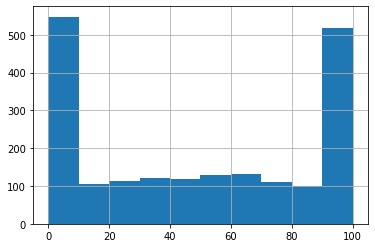

In [36]:
data['fast_k'].hist() ## 변동성이 너무 크다.

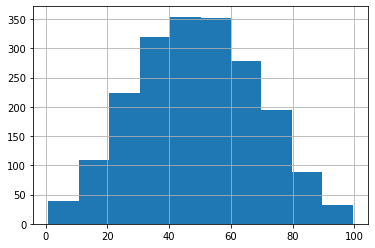

In [37]:
data['slow_k'].hist() # 0과 100 사이에 적절하게 분포

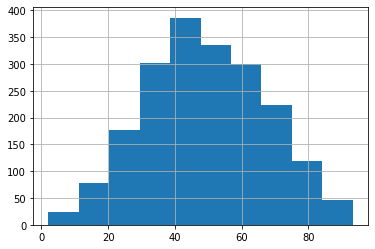

In [38]:
data['slow_d'].hist() # 중간에 몰려 있는 경우

In [39]:
def stoch_oscil(data, in_standard=70, out_standard=30, n=5, m=5, k=3):
    sample = data.copy().reset_index(drop=True)
    sample = get_stochastic_oscil(sample)
    timings = []
    inout_state = []
    var = ['vwap_near', 'vwap_far','volume_near','volume_far']

    timings += [None] * (n+m)
    inout_state += [False] * (n+m)
    isin = False
    for i in range(n+m,len(sample)):
        ## 초기 데이터를 관찰
        ## fast k보다 변동성이 작은 slow k 이용
        score = sample['slow_k'].iloc[i]
        has_null = sample[var].iloc[i].isnull().sum()>0
        in_timing = score >= in_standard 
        out_timing = score <= out_standard
        
        ## 초기 관측 기간이 길게 필요한 모델에는 월물이 교체되는 시기마다
        ## 초기 관측 기간을 두고 새로운 월물의 추세를 좇으려 했으나
        ## 이 경우는 초기 관측 기간이 짧아서
        ## 월물 교체에 대해 따로 고려하지 않음.

        if ~isin & in_timing:
            isin = True
            timings.append('in')
            inout_state.append(isin)
        elif ~isin & ~in_timing:
            timings.append(None)
            inout_state.append(isin)
        elif isin & ~out_timing:
            timings.append('in')
            inout_state.append(isin)            
        elif isin & out_timing:
            isin = False
            timings.append('in')
            inout_state.append(isin) 


    for i in range(1,len(timings)): ## Backtest를 할 때 포지션 진입 시점을 알려주기 위해 변경
            if (timings[i-1]==None) & (timings[i]=='in'):
                timings[i] = 'start'
    
    sample['inout_timing'] = timings
    sample['inout_state'] = inout_state
    
    return sample


In [40]:
sample = stoch_oscil(data=near_far_df_fined, in_standard=70, out_standard=30, n=5, m=5, k=3)

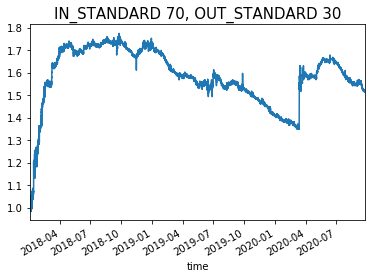

In [41]:
backtest_result = backtest(data=sample, n_mar=0.5, f_mar=0.5, n_lev=5, f_lev=5, in_standard=70, out_standard=30, commission=0.00075)

In [42]:
metrics = Metrics(backtest_result, n_mar=0.5, f_mar=0.5, n_lev=5, f_lev=5, commission=0.00075)

In [43]:
metrics.n_winning

645

In [44]:
metrics.n_losing

163

In [45]:
metrics.n_trades

808

In [46]:
metrics.sharpe_ratio

4.642928135391055

In [47]:
metrics.net_profitability

0.5153678017389045

# Parameter Optimization

In [48]:
## 이상적인 그리드
params_grid = {'in_standard' : [i for i in range(60, 90, 5)], 'out_standard' : [i for i in range(10, 40, 5)], 
               'n' : [i for i in range(3, 7)], 'm' : [i for i in range(60, 90, 5)], 'k' : [i for i in range(60, 90, 5)], 
               'n_mar' : [0.3, 0.4, 0.5, 0.6, 0.7], 'n_lev' : [5, 10, 25, 50], 'f_lev' : [5, 10, 25, 50]}

n_grid=1
for key in params_grid.keys():
    n_grid *= len(params_grid[key])
    
print("Total Iterations : {0}".format(n_grid))

## 시간이 충분하다면 다 돌려볼 수 있다. 하지만 지금은 좀 더 간단한 모델을 사용

Total Iterations : 414720


In [49]:
## 포지션 진입시점과 청산시점을 결정하는 추세 강도 기준을 grid로 설정
params_grid = {'in_standard' : [i for i in range(60, 90, 5)], 'out_standard' : [i for i in range(10, 40, 5)]}
n_grid=1
for key in params_grid.keys():
    n_grid *= len(params_grid[key])
print("Total Iterations : {0}".format(n_grid))


metric_cols=['net_profitability', 'n_trades', 'winning_ratio', 'losing_ratio',
        'MDD', 'largest_win', 'largest_lose', 'sharpe_ratio', 'aver_holding_time', 
         'aver_winning_holding_time', 'aver_losing_holding_time']
verification = pd.DataFrame(np.zeros(shape=(len(metric_cols), n_grid)), index=metric_cols)

Total Iterations : 36


Times for 1 iteration : 48.35575246810913
Times for 2 iteration : 57.79392886161804
Times for 3 iteration : 53.36454224586487
Times for 4 iteration : 53.42124009132385
Times for 5 iteration : 48.29064702987671
Times for 6 iteration : 48.40733480453491
Times for 7 iteration : 49.56748819351196
Times for 8 iteration : 48.51445293426514
Times for 9 iteration : 50.14105558395386
Times for 10 iteration : 66.86124539375305
Times for 11 iteration : 48.681615352630615
Times for 12 iteration : 48.25983428955078
Times for 13 iteration : 48.05677628517151
Times for 14 iteration : 49.15610456466675
Times for 15 iteration : 76.91814255714417
Times for 16 iteration : 74.19865584373474
Times for 17 iteration : 56.31745672225952
Times for 18 iteration : 58.258267641067505
Times for 19 iteration : 56.7433180809021
Times for 20 iteration : 57.34769892692566
Times for 21 iteration : 56.793200969696045
Times for 22 iteration : 56.01624321937561
Times for 23 iteration : 56.127962827682495
Times for 24 iter

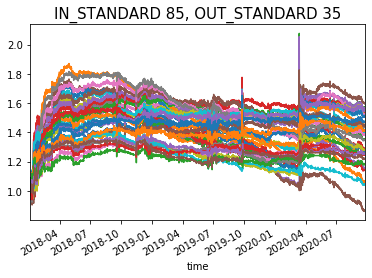

In [50]:
count = 0
metrics_save = []
in_standard_list = []
out_standard_list= []
for in_standard in params_grid['in_standard']:
    for out_standard in params_grid['out_standard']:
        try:
            in_standard_list.append(in_standard)
            out_standard_list.append(out_standard)
            start = time.time()
            sample = stoch_oscil(data=near_far_df_fined, in_standard=in_standard, out_standard=out_standard, n=5, m=5, k=3)
            backtest_result = backtest(data=sample, n_mar=0.5, f_mar=0.5, n_lev=5, f_lev=5, commission=0.00075, in_standard=in_standard, out_standard=out_standard)
            metrics = Metrics(backtest_result, n_mar=0.5, f_mar=0.5, n_lev=5, f_lev=5, commission=0.00075)
            metrics_save.append(metrics)
            verification.iloc[:,count] = [metrics.net_profitability, metrics.n_trades, metrics.percen_winning, 
                            metrics.percen_losing, metrics.mdd, metrics.largest_winning, metrics.largest_losing, 
                            metrics.sharpe_ratio, metrics.aver_holding_time, metrics.aver_winning_holding_time,
                            metrics.aver_losing_holding_time]

            end = time.time()
            count+=1
            print('Times for {0} iteration : {1}'.format(count, end-start))            
        except Exception as e:
            print(e)
            
grid = pd.DataFrame([in_standard_list, out_standard_list], index=['in_standard', 'out_standard'])
verification = pd.concat([verification, grid])
verification = verification.T

In [52]:
index = []
for in_standard in params_grid['in_standard']:
    for out_standard in params_grid['out_standard']:
        ind = '({0},{1})'.format(in_standard, out_standard)
        index.append(ind)
verification.index = index

In [53]:
verification.head(3)

,net_profitability,n_trades,winning_ratio,losing_ratio,MDD,largest_win,largest_lose,sharpe_ratio,aver_holding_time,aver_winning_holding_time,aver_losing_holding_time,in_standard,out_standard
"(60,10)",0.44379,254,0.728346,0.267717,0.964135,0.079969,-0.0357759,5.93005,3 days 13:12:19.920948,2 days 20:48:38.918918,5 days 09:48:31.764705,60,10
"(60,15)",0.281507,404,0.74505,0.252475,0.649954,0.0626457,-0.0366495,6.72655,2 days 02:12:30.372208,1 days 17:30:17.940199,3 days 03:53:31.764705,60,15
"(60,20)",0.260931,565,0.748673,0.249558,0.556555,0.196593,-0.0711131,3.30173,1 days 09:13:17.872340,1 days 03:52:20.425531,2 days 01:16:10.212765,60,20


In [54]:
# verification = pd.read_pickle('verification.pkl')

In [55]:
float_col = ['net_profitability', 'n_trades', 'winning_ratio', 'losing_ratio', 'MDD',
       'largest_win', 'largest_lose', 'sharpe_ratio']
time_col = ['aver_holding_time','aver_winning_holding_time', 'aver_losing_holding_time']
int_col = ['in_standard','out_standard']
verification[float_col] = verification[float_col].applymap(lambda x: float(x))
verification[time_col] = verification[time_col].applymap(lambda x: x.total_seconds())
verification[int_col] = verification[int_col].applymap(lambda x: int(x))                                

In [56]:
verification.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, (60,10) to (85,35)
Data columns (total 13 columns):
net_profitability            36 non-null float64
n_trades                     36 non-null float64
winning_ratio                36 non-null float64
losing_ratio                 36 non-null float64
MDD                          36 non-null float64
largest_win                  36 non-null float64
largest_lose                 36 non-null float64
sharpe_ratio                 36 non-null float64
aver_holding_time            36 non-null float64
aver_winning_holding_time    36 non-null float64
aver_losing_holding_time     36 non-null float64
in_standard                  36 non-null int64
out_standard                 36 non-null int64
dtypes: float64(11), int64(2)
memory usage: 3.9+ KB


In [57]:
## 최종수익률 기준 상위 5개와 하위 5개의 가격 추이
top5 = verification.sort_values(by='net_profitability', ascending=False).head(5)
bot5 = verification.sort_values(by='net_profitability', ascending=False).tail(5)

In [58]:
def find_index(in_standard, out_standard):
    in_loc = params_grid['in_standard'].index(in_standard)
    out_loc =  params_grid['out_standard'].index(out_standard)
    loc = 6*in_loc+out_loc
    return loc

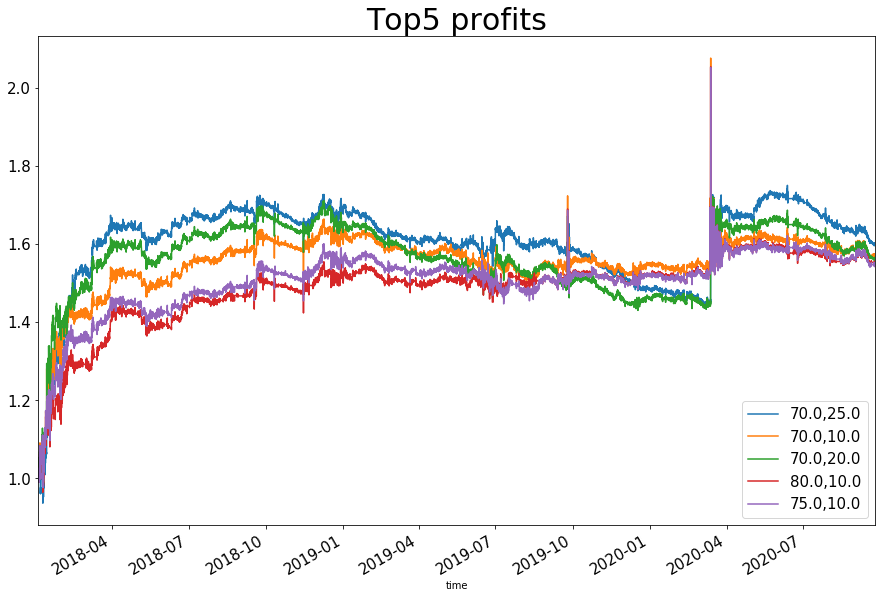

In [59]:
plt.title('Top5 profits', fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
legend = []
for i in range(len(top5)):
    in_standard = top5.iloc[i]['in_standard']
    out_standard = top5.iloc[i]['out_standard']
    met_ind = find_index(in_standard, out_standard)
    metrics_save[met_ind].data['realized_bal_com'].plot(figsize=(15,10))
    legend.append('{0},{1}'.format(in_standard, out_standard))
    
plt.legend(legend, fontsize=15,loc='lower right')

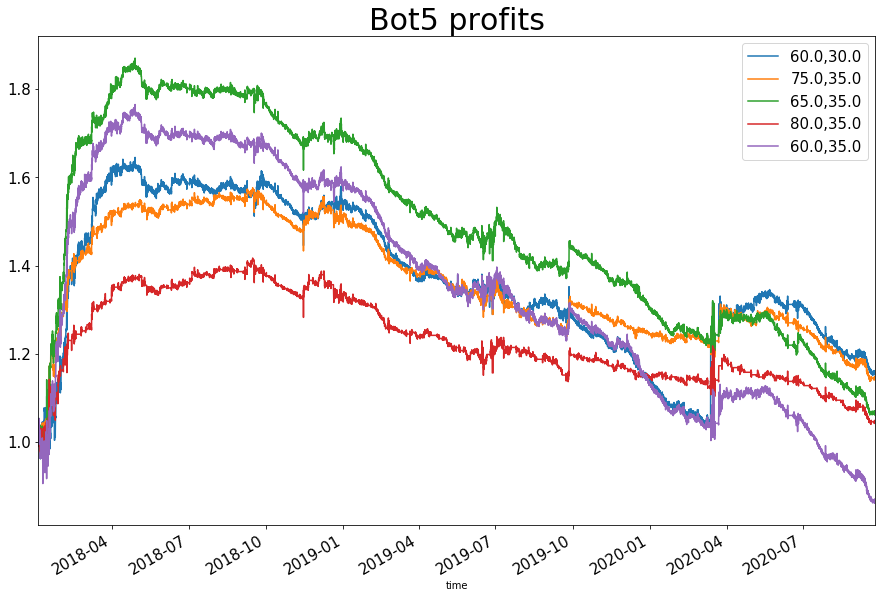

In [74]:
plt.title('Bot5 profits', fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
legend = []
for i in range(len(bot5)):
    in_standard = bot5.iloc[i]['in_standard']
    out_standard = bot5.iloc[i]['out_standard']
    met_ind = find_index(in_standard, out_standard)
    metrics_save[met_ind].data['realized_bal_com'].plot(figsize=(15,10))
    legend.append('{0},{1}'.format(in_standard, out_standard))
    
plt.legend(legend, fontsize=15,loc='upper right')

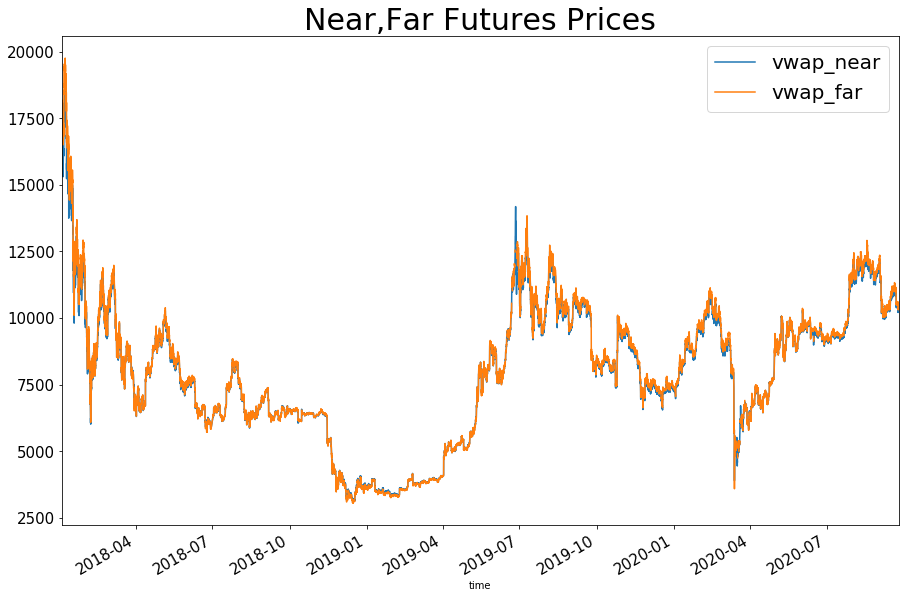

In [96]:
near_far_futures = near_far_df_fined[['vwap_near', 'vwap_far']]
near_far_futures.index = near_far_df_fined['time']
near_far_futures.plot(figsize=(15,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Near,Far Futures Prices', fontsize=30)
plt.legend(['vwap_near', 'vwap_far'], fontsize=20,loc='upper right')

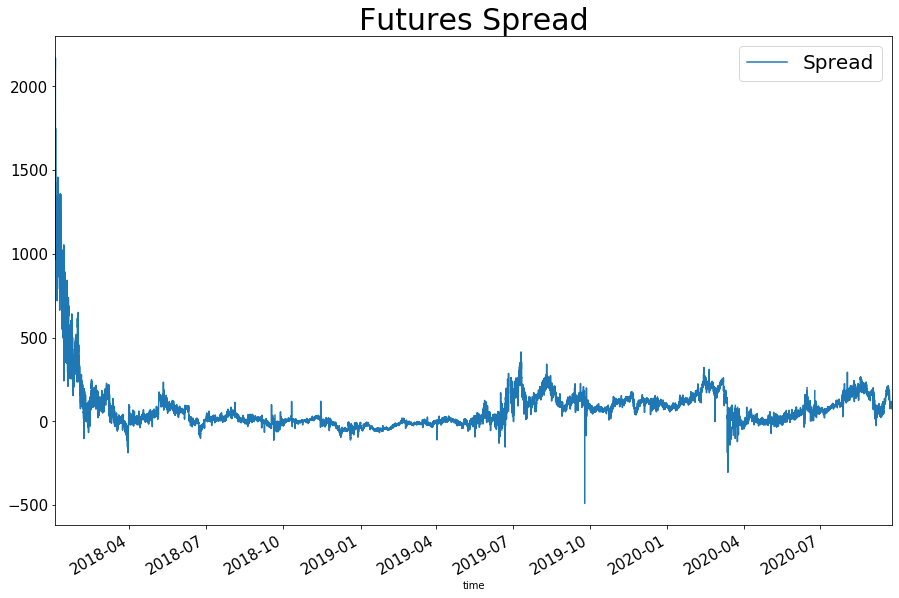

In [100]:
near_far_spread = near_far_df_fined['spread']
near_far_spread.index = near_far_df_fined['time']
near_far_spread.plot(figsize=(15,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Futures Spread', fontsize=30)
plt.legend(['Spread'], fontsize=20,loc='upper right')

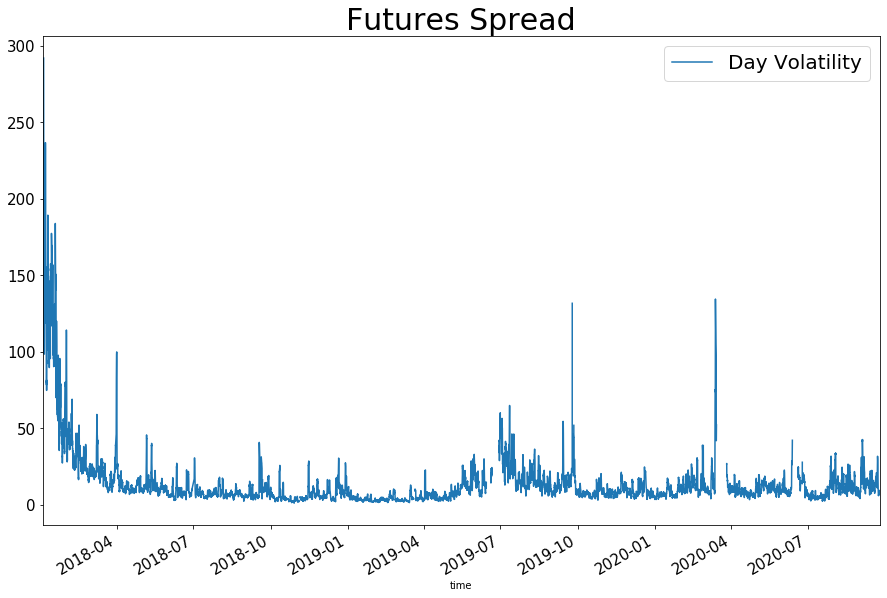

In [101]:
day_vol = near_far_spread.rolling(24).std()
day_vol.plot(figsize=(15,10))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Futures Spread', fontsize=30)
plt.legend(['Day Volatility'], fontsize=20,loc='upper right')

## Spread의 변동성은 선물가격이 급격하게 감소하는 시기, 심지어 백워데이션이 발생하는 시기에 급격히 증가한다. 암호화폐처럼 지급을 확실히 담보할 수 없는 자산은 어떤 악재에 마주쳤을 때 급락할 가능성이 높다. 미래에 비트코인의 급락으로 스프레드 변동성이 일시적으로만 확대되는 경우 청산기준이  높아서 자주 청산을 하는 경우는 거래 수수료로 인해 손실이 확대될 수 있다.

## Top5와 Bot5의 차이는 2018년 1분기와 2020년 1분기의 성과에서 가장 두드러진다. Bot5는 청산기준이 높은 grid인데, 스프레드 변동성이 확대되면 수익을 얻고, 횡보하는 경우 손해를 본다. Top5는 청산기준이 낮은 grid들인데, 스프레드 변동성이 감소하여 횡보하는 경우 수익을 얻고, 변동성이 확대될 때는 수익이 제한된다. 

## 이는 변동성이 클 때는 잦은 거래로 인한 수익이 수수료 비용을 초과하지만, 변동성이 낮을 때는 수수료 비용이 더 커서 손실로 이어진다는 것을 의미한다.

## 지금의 모델은 진입기준과 청산기준이 전기간에 대해 일정하다고 가정하지만, 추후에 이를 수정하여 변동성이 확대될 때는 청산기준과 레버리지를 높여서 거래 횟수를 늘리고, 변동성이 감소하면 청산기준과 레버리지를 낮추어 거래횟수를 줄이는 전략을 사용할 수 있다.

In [61]:
verification.describe(include='all')
## winning_ratio가 평균적으로 77%가 나오는 것으로 봐서, Stochastic Oscillator는 좋은 추세지표로 볼 수 있다.
## 그리고 largest_win이 21.1%인데 반해 largest_lose는 -7.3%인 것으로 보아 손실 방어를 하기에 적합하다.

,net_profitability,n_trades,winning_ratio,losing_ratio,MDD,largest_win,largest_lose,sharpe_ratio,aver_holding_time,aver_winning_holding_time,aver_losing_holding_time,in_standard,out_standard
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.353776,521.416667,0.773312,0.224854,0.721419,0.122707,-0.036405,4.832949,130189.164124,106001.806279,207032.410721,72.500000,22.500000
std,0.171537,262.768815,0.028808,0.027476,0.209498,0.068812,0.011740,1.788717,96273.006651,77552.153317,146848.730702,8.660254,8.660254
min,-0.136784,175.000000,0.716102,0.174684,0.375651,0.047869,-0.072510,1.394339,38160.000000,31988.571429,65582.608696,60.000000,10.000000
25%,0.252310,327.250000,0.754808,0.202073,0.570390,0.062515,-0.035194,3.377589,52353.712871,42893.693748,91282.503870,65.000000,15.000000
50%,0.386298,454.000000,0.771255,0.226316,0.701737,0.079969,-0.035000,5.033359,96598.474634,78597.231834,150179.933969,72.500000,22.500000
75%,0.506973,685.500000,0.797927,0.242067,0.866935,0.198344,-0.032771,6.132843,180766.378128,146366.985050,295831.736273,80.000000,30.000000
max,0.597852,1159.000000,0.825316,0.279661,1.103647,0.211364,-0.022647,8.533383,329793.103448,282035.820896,500277.966102,85.000000,35.000000


Average Between Grids : 0.3537764810691483
Standard Deviation Between Grids : 0.17153665104428556
Loss Case Ratio  : 0.0278


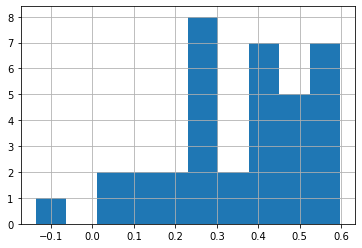

In [85]:
verification['net_profitability'].hist()
print('Average Between Grids : {0}'.format(verification['net_profitability'].mean()))
print('Standard Deviation Between Grids : {0}'.format(verification['net_profitability'].std()))
loss_case_ratio = round((verification['net_profitability'] < 0).sum() / len(verification),4)
print('Loss Case Ratio  : {0}'.format(loss_case_ratio))
## 손실이 나는 경우는 36개 중에 1개로, 매우 작은 부분을 차지한다.

,n_trades,net_profitability
n_trades,1.00000,-0.59149
net_profitability,-0.59149,1.00000


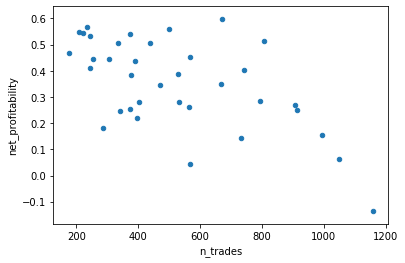

In [102]:
verification.plot.scatter(x='n_trades', y='net_profitability')
verification[['n_trades', 'net_profitability']].corr()
## 거래 횟수가 늘어날수록 최종 수익률이 낮아진다.
## 이는 수익률에 수수료가 미치는 영향이 크다는 것을 보여준다

,net_profitability,sharpe_ratio
net_profitability,1.000000,0.710175
sharpe_ratio,0.710175,1.000000


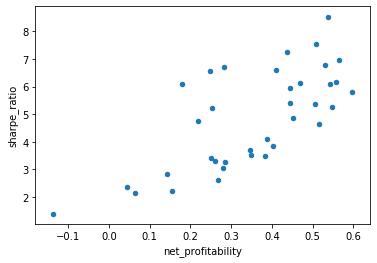

In [103]:
verification.plot.scatter(x='net_profitability', y='sharpe_ratio')
verification[['net_profitability', 'sharpe_ratio']].corr()
## sharpe ratio가 net_profitability에 강한 영향을 받는다는 점은 전략들마다 변동성의 차이가 그렇게 크지 않음을 의미

,net_profitability,MDD
net_profitability,1.000000,0.445894
MDD,0.445894,1.000000


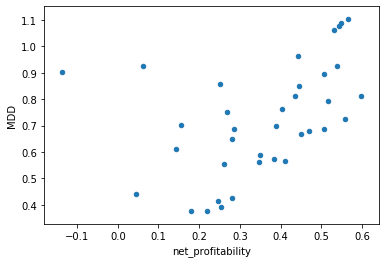

In [104]:
verification.plot.scatter(x='net_profitability', y='MDD')
verification[['net_profitability', 'MDD']].corr()
## 전체 수익이 클수록 MDD가 큰 경향이 있다는 점은 모든 전략마다 하방 손실 구간은 큰 차이가 없다고 볼 수 있다.

(                   in_standard  net_profitability
 in_standard           1.000000           0.086199
 net_profitability     0.086199           1.000000,
                    out_standard  net_profitability
 out_standard           1.000000          -0.718006
 net_profitability     -0.718006           1.000000)

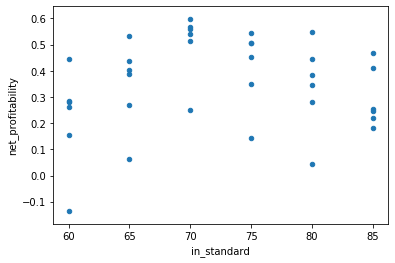

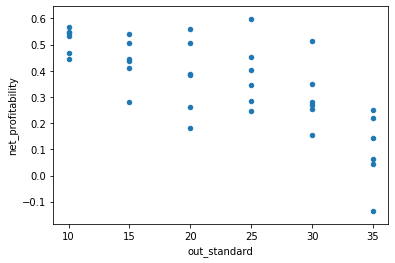

In [106]:
verification.plot.scatter(x='in_standard', y='net_profitability')
verification.plot.scatter(x='out_standard', y='net_profitability')
verification[['in_standard', 'net_profitability']].corr(), verification[['out_standard', 'net_profitability']].corr()
## 진입하는 기준을 엄격하게 하는 것은(in_standard를 높이는 것) net_profitability와 큰 상관성이 보이지 않는다.
## 하지만 포지션을 청산하는 기준은 낮을 수록 net_profitability가 커짐을 알 수 있다.

,out_standard,largest_win
out_standard,1.000000,0.172783
largest_win,0.172783,1.000000


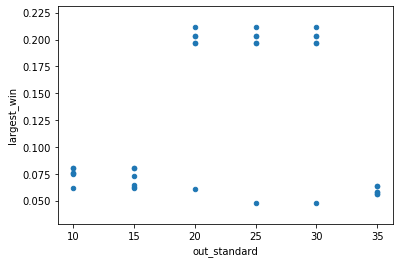

In [107]:
verification.plot.scatter(x='out_standard', y='largest_win')
verification[['out_standard', 'largest_win']].corr()
## 청산기준을 낮추면 가능한 최대 수익의 크기는 상대적으로 적다.

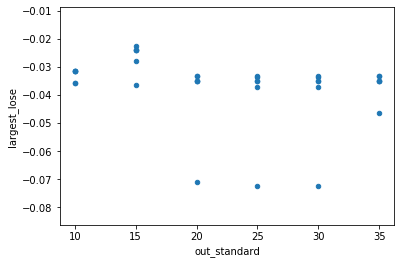

In [109]:
verification.plot.scatter(x='out_standard', y='largest_lose')
## 낮은 청산 기준은 최대 하방 손실과는 큰 관계가 없다.
## 오히려 청산 기준이 높아서 잦은 청산을 하는 경우에 large loss가 발생한다.

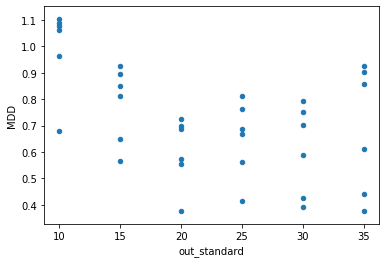

In [68]:
verification.plot.scatter(x='out_standard', y='MDD')
## 청산기준이 낮을수록 MDD가 크다. 하지만 이를 단순히 청산기준을 낮추는 것이 더 위험하다고 볼 수는 없다.
## 왜냐하면 MDD는 하방손실이 일정 수준으로 고정되어 있을 때는
## net_profit이 클수록 커지기 때문이다.

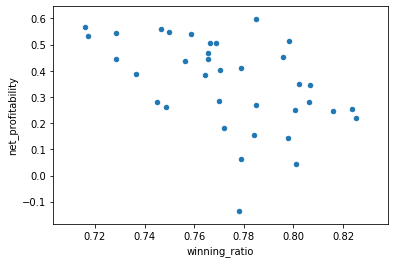

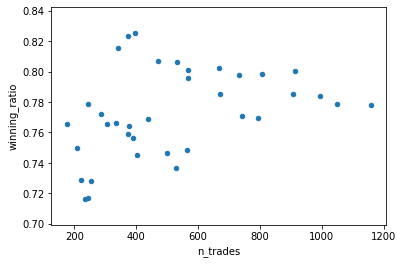

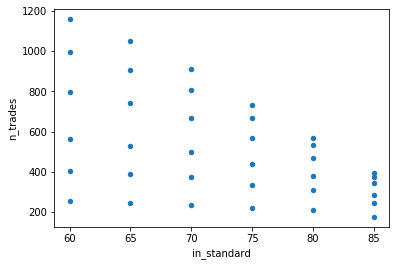

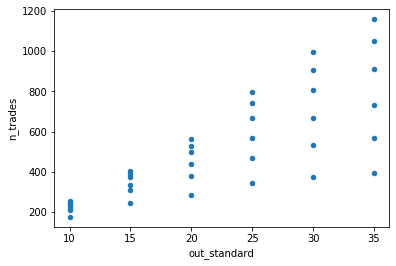

In [69]:
verification.plot.scatter(x='winning_ratio', y='net_profitability')
verification.plot.scatter(x='n_trades', y='winning_ratio')
verification.plot.scatter(x='in_standard', y='n_trades')
verification.plot.scatter(x='out_standard', y='n_trades')
## 아이러니하게도 winning ratio가 높다고 해서 net_profitability가 높은 것이 아니다.
## winning_ratio는 거래 횟수와 큰 양의 상관관계가 있다.
## 진입기준을 낮추고, 청산기준을 높이면 거래가 잦아지고, winning trade의 비율은 높아지지만
## 수수료의 영향으로 인해 net_profitability는 감소함을 보여준다.
## 직관적으로 생각하면 winning ratio가 높아짐에 따라 어느 시점까지는 net_profitability가 증가하다
## 너무 높아지면 net_profitability가 떨어질 것으로 예측할 수 있다.
## 하지만 실제 결과는 winning ratio와 net_profitability가 선명한 음의 상관관계를 가진다.
## 이는 레버리지 투자에서 수수료가 차지하는 비중이 얼마나 큰 지를 보여주며,
## 이러한 경향은 레버리지를 높여 투자함에 따라 더 크게 드러날 것을 예측할 수 있다.

,aver_holding_time,net_profitability
aver_holding_time,1.000000,0.610431
net_profitability,0.610431,1.000000


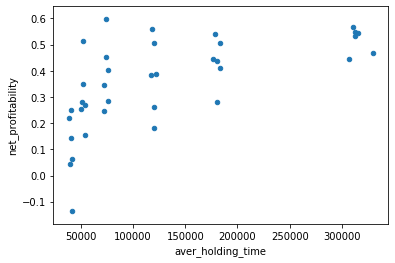

In [110]:
verification.plot.scatter(x='aver_holding_time', y='net_profitability')
verification[['aver_holding_time', 'net_profitability']].corr()
## holding time과 net_profit은 양의 상관관계를 가진다. 
## 최대한 거래를 줄여 수수료를 줄이는 것이 중요하다는 점을 다시 한 번 보여준다.

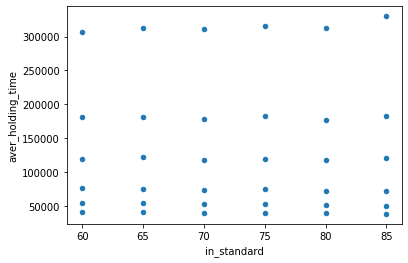

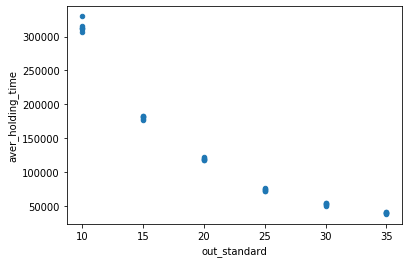

In [71]:
verification.plot.scatter(x='in_standard', y='aver_holding_time')
verification.plot.scatter(x='out_standard', y='aver_holding_time')
## 진입기준보다 청산기준이 holding time에 영향을 많이 준다.
## 청산기준과 holding time은 지수적인 관계를 보인다.
## 위에서 봤던 것처럼 진입기준는 청산기준 net_profitability를 결정하는데 중요했던 것처럼
## holding_time도 청산기준에 큰 영향을 받는다. 

# 파라미터 최적화 결과 종합
## 요약 : 존버가 이긴다.


## 진입기준보다는 청산기준이 Net Profitability에 큰 영향을 준다. 청산기준이 낮을 수록 Net Profitablity가 크다. 이는 레버리지를 이용한 선물 스프레드 거래에는 수수료 비중이 매우 큰 영향을 차지하여, 잦은 청산을 하는 경우 수익이 악화된다는 점을 보여준다. 그리고 일반적인 생각과 달리 청산을 빠르게 끝낸다고 해도 최대 하방손실은 줄이기 힘들며, 청산기준이 낮아도 하방손실을 어느 정도로 유지된다. 청산기준을 낮추었을 때 한 가지 단점이라면 얻을 수 있는 최대 수익의 크기가 줄어든다는 점이다. 하지만 이 또한 수수료를 아낄 수 있다는 점으로 인하여 충분히 상쇄될 수 있다.

In [72]:
verification.sort_values(by='net_profitability', ascending=False).head(10)

,net_profitability,n_trades,winning_ratio,losing_ratio,MDD,largest_win,largest_lose,sharpe_ratio,aver_holding_time,aver_winning_holding_time,aver_losing_holding_time,in_standard,out_standard
"(70,25)",0.597852,670.0,0.785075,0.214925,0.813924,0.203598,-0.035000,5.800750,73821.492537,61514.828897,118775.000000,70,25
"(70,10)",0.565926,236.0,0.716102,0.279661,1.103647,0.075389,-0.031593,6.975247,311116.595745,243244.970414,484909.090909,70,10
"(70,20)",0.558062,501.0,0.746507,0.251497,0.726350,0.203598,-0.035000,6.175963,118188.000000,94629.946524,188114.285714,70,20
"(80,10)",0.548127,208.0,0.750000,0.245192,1.089688,0.074481,-0.031593,5.271200,312660.869565,254930.769231,489247.058824,80,10
"(75,10)",0.543535,221.0,0.728507,0.266968,1.076181,0.075389,-0.031593,6.110913,315212.727273,247393.788820,500277.966102,75,10
"(70,15)",0.539152,373.0,0.758713,0.238606,0.926236,0.080355,-0.024120,8.533383,178006.451613,141341.342756,294593.258427,70,15
"(65,10)",0.531611,244.0,0.717213,0.278689,1.063235,0.079969,-0.035776,6.796640,312444.444444,251753.142857,468635.294118,65,10
"(70,30)",0.515368,808.0,0.798267,0.201733,0.791671,0.203598,-0.035000,4.642928,52404.950495,42535.813953,91457.668712,70,30
"(75,15)",0.507558,334.0,0.766467,0.230539,0.893714,0.073254,-0.024120,7.537213,183459.459459,145350.000000,310161.038961,75,15
"(75,20)",0.506778,437.0,0.768879,0.228833,0.685711,0.203598,-0.035000,5.357057,120005.504587,98742.857143,191448.000000,75,20


## 최대의 net_profitability을 주는 파라미터 조합은 (70,25)이다. 하지만 위의 데이터 분석 결과 청산기준을 가능하면 낮추는 것이 위험 측면에서 더 나은 경우가 있다는 점을 알 수 있다. 위험을 고려한 지표인 sharpe ratio는 (70,10)일 때 6.98, (70,15)일 때 8.533383로, (70,25)의 5.80보다 높다. 그리고 청산기준은 조금만 차이나도 holding time에 큰 영향을 준다. 비이성적인 시장상황에서 holding time이 지나치게 길어지는 점도 위험할 수 있다.만약 내가 파라미터를 정한다면 이러한 정보들을 종합적으로 고려하여 sharpe ratio가 가장 높고, 수익률도 54%로 최댓값과 약 5% 차이가 나며, holding period도 중간 수준으로 유지할 수 있는 (70,15)를 선택할 것이다. 

# 개선 사항
 ## - 전략 측면 : grid의 갯수가 상당히 커서 현실적으로 다 탐색할 수 없다. 그럴 때는 코드를 수정하여 실행시간을 줄이는 방법, 그리고 몇 가지 grid를 random_sampling하여 변수별 변동을 분석하여 최적점을 찾아나갈 수 있다.  Stochastic Oscillator이외에 MACD 등 다양한 기술적 지표 투자전략이 존재하는데, 이를 시도해볼 시간이 부족. 그리고 레버리지, 포지션 크기, 청산기준을 매 기간마다 일정하다고 가정했으나, 더 향상된 모델은 시장 spread의 크기, 변동성, 거래량에 따라 이러한 변수들을 조정할 수 있다.

 ## - 코딩 측면 : pandas의 병렬처리를 잘 써서 실행 시간을 줄이면 현실적으로 더 많은 parameter grid를 탐색할 수 있을 것이다. 그리고 backtest를 함수가 아니라 class로 만들었다면 좀 더 다양한 방법으로 이용할 수 있었을 것이다. 
 
 ## - 데이터 처리 측면 : 근월물 만기가 오기 전에 차차월물 거래가 시작되는 경우, 차월물과 차차월물의 스프레드에만 투자할 수 있다고 가정했다. 두 개의 스프레드가 동시에 존재하는 기간들의 그래프를 몇 개 그려보면 (근월물, 차월물) 스프레드와 (차월물, 차차월물) 스프레드는 양의 상관관계를 보이지는 않는다. 즉, 음의 상관계수이거나 독립이다. 따라서 또 다른 스프레드 축소 타이밍을 잡을 수 있다. 결측치가 너무 많아서 상관계수를 구하기가 어려워 그래프 개형을 보고 판단하였다. 따라서 이 기간을 더 잘 이용하면 더 좋은 수익이 가능할 것이다. 왜냐하면 한 쪽의 스프레드가 확장될 때, 다른 한 쪽은 축소된다면 또 다른 수익 기회가 존재하는 것으로 볼 수 있기 때문이다. 이 기간 동안 (근월물, 차월물) 스프레드 (차월물, 차차월물) 스프레드를 동시에 보고 접근할 수 있게 하기. 
 
 ## - 가정과 현실의 차이 : 시장상황에 상관없이 레버리지는 동일하게 가져간다고 가정했다. 하지만 추세의 강도에 따라 레버리지에 변화를 주어 투자한다면 더 좋은 투자수익률을 거둘 수 있을 것으로 생각. 